## Import Libraries

In [1]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

/home/aaagraw/anaconda3/envs/fastainew/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
import librosa
import soundfile as sf
from pydub import AudioSegment
from tqdm.notebook import tqdm

## Load and Explore Audio

In [4]:
trainPath = Path("../data/urbanSoundClassification/wav/Train/")

In [5]:
## Load path for all audio in a list
audioFilesList = get_audio_files(trainPath)

In [6]:
## Getting metadata about the audios
errorAudioPath = []
durationList , frameRateList, channelsList, peakAmpList = [], [], [], []
for audioPath in tqdm(audioFilesList):
    try:
        arr = AudioSegment.from_wav(audioPath)
        durationList.append(arr.duration_seconds)
        frameRateList.append(arr.frame_rate)
        channelsList.append(arr.channels)
        peakAmpList.append(arr.max)
    except:
        errorAudioPath.append(audioPath)

count    5433.000000
mean        3.594254
std         0.997000
min         0.050000
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
dtype: float64


<AxesSubplot:ylabel='Frequency'>

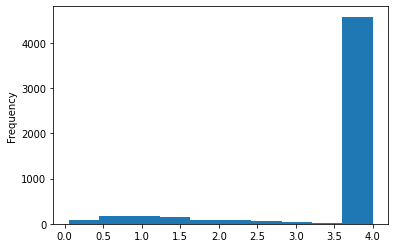

In [30]:
## Most of the files are 4 sec duration
print(pd.Series(durationList).describe())
pd.Series(durationList).plot(kind='hist')

44100    3254
48000    1663
96000     359
24000      53
16000      39
22050      35
11025      20
8000        6
32000       4
dtype: int64


<AxesSubplot:ylabel='Frequency'>

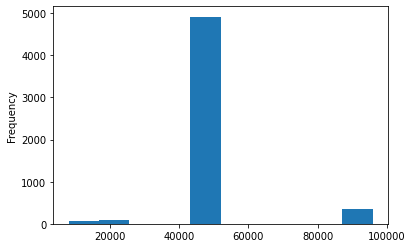

In [33]:
## Files have variable sample rate most of it is  44100, 48000
print(pd.Series(frameRateList).value_counts())
pd.Series(frameRateList).plot(kind='hist')

2    5004
1     429
dtype: int64


<AxesSubplot:ylabel='Frequency'>

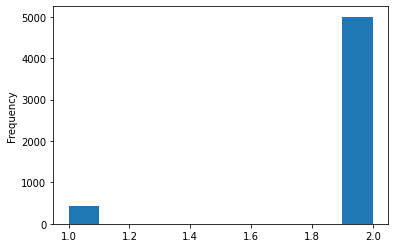

In [35]:
## Many files have dual channel audio 
print(pd.Series(channelsList).value_counts())
pd.Series(channelsList).plot(kind='hist')

count    5.433000e+03
mean     2.762328e+08
std      5.384277e+08
min      1.000000e+01
0%       1.000000e+01
25%      1.161400e+04
50%      2.397900e+04
75%      3.262528e+08
80%      4.877961e+08
90%      1.086697e+09
max      2.147483e+09
dtype: float64


<AxesSubplot:ylabel='Frequency'>

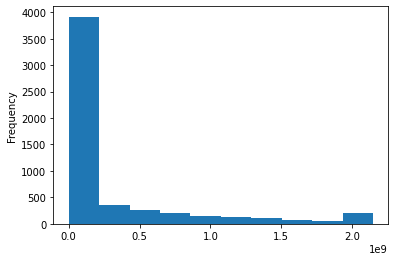

In [44]:
## Maximum amplitude varies
print(pd.Series(peakAmpList).describe(percentiles=[0,0.25, 0.5,0.75, 0.8, 0.9]))
pd.Series(peakAmpList).plot(kind='hist')

## Data processing

In [7]:
opPath = '../data/urbanSoundClassification/wav/processed/train/'

In [137]:
## Function to process audio into a standard format (Mono 48000 Sample rate)
def audioProcessing(ipPath, opPath):
    arr, sr = librosa.load(ipPath, sr = 48000, mono=False)
    arr_mono = librosa.to_mono(arr)
    sf.write(
        opPath+ipPath.name, 
        arr_mono, 
        samplerate=48000, 
        subtype='PCM_16'
    )

In [138]:
## Training Data
for audioPath in tqdm(get_audio_files(trainPath)):
    audioProcessing(audioPath, opPath = opPath)

In [8]:
## Testing data
testPath = Path('../data/urbanSoundClassification/wav/Test/')
opPathTest = '../data/urbanSoundClassification/wav/processed/test/'

In [150]:
for audioPath in tqdm(get_audio_files(testPath)):
    audioProcessing(audioPath, opPath =  opPathTest)

## Load Audio

In [9]:
trainDf = pd.read_csv("../data/urbanSoundClassification/train_fuSp8nd.csv")
trainDf['filename'] = trainDf.ID.apply(lambda x: opPath+str(x)+".wav")

In [10]:
trainDf.head()

,ID,Class,filename
0,0,siren,../data/urbanSoundClassification/wav/processed/train/0.wav
1,1,street_music,../data/urbanSoundClassification/wav/processed/train/1.wav
2,2,drilling,../data/urbanSoundClassification/wav/processed/train/2.wav
3,3,siren,../data/urbanSoundClassification/wav/processed/train/3.wav
4,4,dog_bark,../data/urbanSoundClassification/wav/processed/train/4.wav


In [11]:
cfg = AudioConfig.BasicMelSpectrogram(
    sample_rate=48000, 
    n_fft=1024, 
    hop_length=128, 
    f_min=0, 
    f_max = 8000, 
    pad=0,
    n_mels = 64,
    power = 2,
    normalized = False,
    mel = True,
    to_db = False
)
a2s = AudioToSpec.from_cfg(cfg)

In [35]:
cfg = AudioConfig.BasicSpectrogram()
a2s = AudioToSpec.from_cfg(cfg)

In [36]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename"), 
                 splitter = RandomSplitter(0.2),
                 batch_tfms = None,
                 item_tfms=[
                     ResizeSignal(4000, pad_mode=AudioPadType.Repeat),
                     SignalShifter(p=0.5, max_pct=0.2),
                     a2s,
                     MaskFreq(2, size=10), 
                     MaskTime(2, size=10)]
                 , 
                 get_y = ColReader("Class"))

In [37]:
dbunch = auds.dataloaders(trainDf, bs=32)

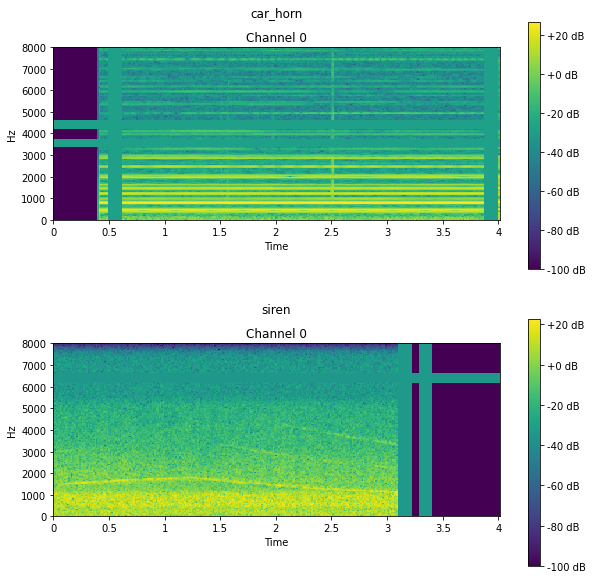

In [38]:
dbunch.show_batch(figsize=(10, 10))

In [39]:
learn = cnn_learner(dbunch, 
            resnet18,
            config=cnn_config(n_in=1), #<- Only audio specific modification here
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.0012022644514217973)

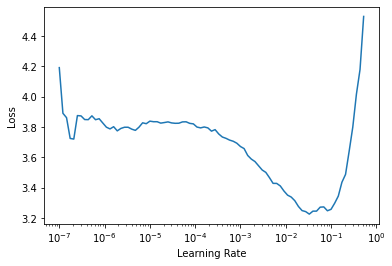

In [85]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.793083,1.013607,0.673413,00:26
1,1.272739,1.431448,0.637534,00:23
2,0.990436,0.814589,0.760810,00:23
3,0.825549,0.874300,0.727691,00:23
4,0.658020,0.522030,0.829807,00:23
5,0.516767,0.453892,0.857406,00:23
6,0.399319,0.399921,0.881325,00:23
7,0.326278,0.246343,0.928243,00:24
8,0.292783,0.224593,0.934683,00:26


In [79]:
learn.export('./models/resnet18_local_stg2.pkl')

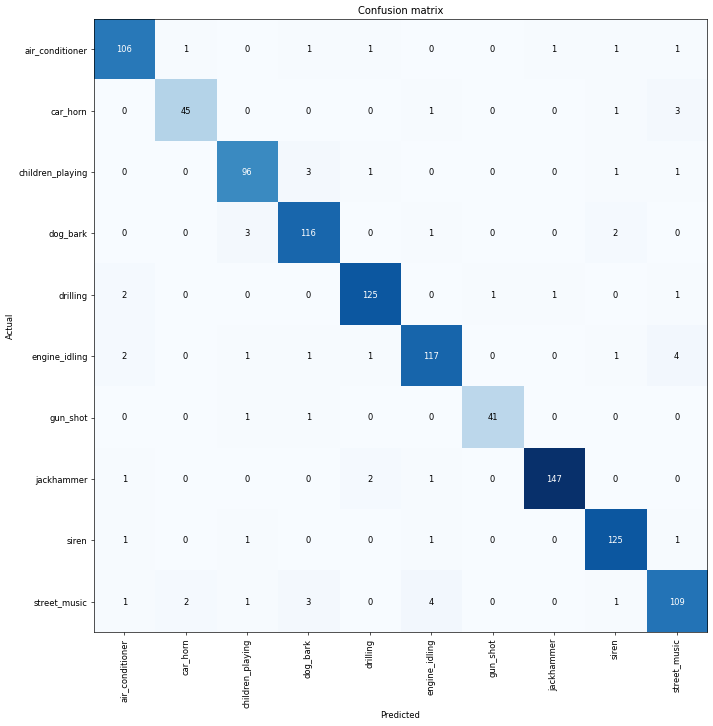

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Looks Good!

## Inference

In [17]:
testDf = pd.read_csv("../data/urbanSoundClassification/test_B0QdNpj.csv")
testDf['filename'] = testDf.ID.apply(lambda x: opPathTest+str(x)+".wav")
testDf.head()

,ID,filename
0,5,../data/urbanSoundClassification/wav/processed/test/5.wav
1,7,../data/urbanSoundClassification/wav/processed/test/7.wav
2,8,../data/urbanSoundClassification/wav/processed/test/8.wav
3,9,../data/urbanSoundClassification/wav/processed/test/9.wav
4,13,../data/urbanSoundClassification/wav/processed/test/13.wav


In [18]:
## Making Test dataloader
test_dl = learn.dls.test_dl(testDf)

In [19]:
## Test time augmentation TTA
preds,_ = learn.tta(dl=test_dl, n=8)

In [ ]:
## Using this if you don't want TTA
#preds,_ = learn.get_preds(dl = test_dl)

In [20]:
## Get vocab
vocab_dict={idx:x for idx,x in enumerate(learn.dls.vocab)}

In [31]:
predictions = pd.Series(np.array(preds).argmax(axis=1)).apply(lambda x: vocab_dict[x])
testDf_copy = testDf.iloc[test_dl.get_idxs(),:].reset_index(drop=True).copy()
testDf_copy['Class'] = predictions

In [32]:
testDf_copy.loc[:,['Class','ID']].to_csv('./submission.csv', index=False)